### Install

In [ ]:
!pip install gmft -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 14.3 MB/s eta 0:00:00


### Paper 1: TATR

We will use the original paper that introduced the Table Transformer (TATR): "PubTables-1M: Towards comprehensive table extraction from unstructured documents" by Smock, Pesala, and Abraham.

In [2]:
# get the PubTables-1M paper, source of original Table Transformer (TATR)
!mkdir ./samples
!wget -O ./samples/tatr.pdf -q https://arxiv.org/pdf/2110.00061

mkdir: cannot create directory ‘./samples’: File exists


In [2]:
from gmft.pdf_bindings import PyPDFium2Document
from gmft import CroppedTable, TableDetector

detector = TableDetector()

def ingest_pdf(pdf_path) -> list[CroppedTable]:
    doc = PyPDFium2Document(pdf_path)

    tables = []
    for page in doc:
        tables += detector.extract(page)
    return tables, doc


In [3]:
tables, doc = ingest_pdf('./samples/tatr.pdf')
len(tables)

6

There are 6 matches. Let's view all the identified tables.

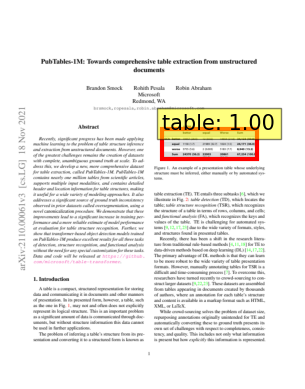

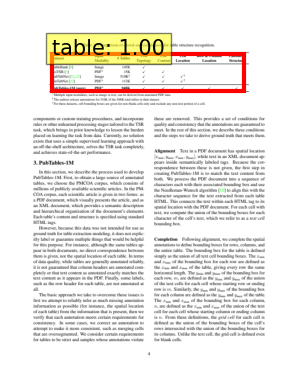

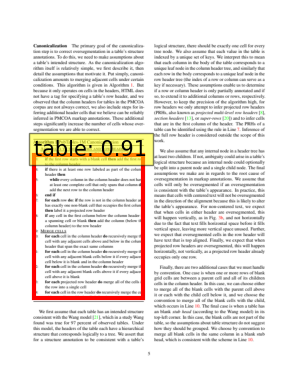

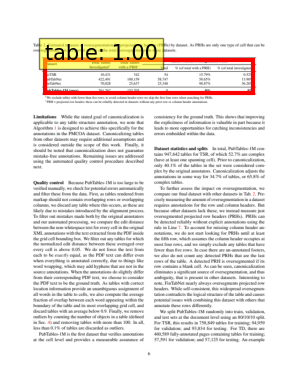

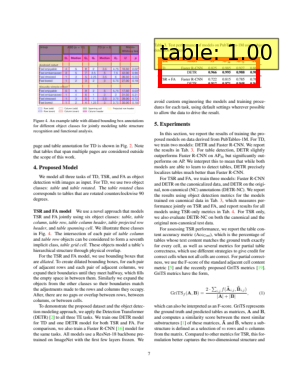

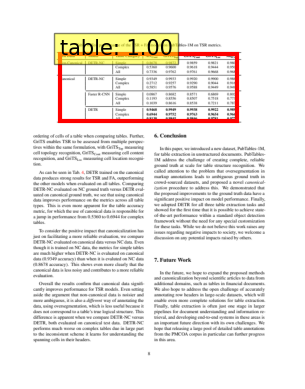

In [4]:
# display several images
# decrease size with plt
for table in tables:
    table.visualize(figsize=None)

In gmft, a `CroppedTable` is a region where a table has been detected. However, for speed, the text is not automatically extracted. To do this, you will need a `TableFormatter`. Specifically, the `AutoTableFormatter` is recommended (which currently points to `TATRTableFormatter`).

Let's work through the tables in order.

In [5]:
from gmft import AutoTableFormatter

formatter = AutoTableFormatter()

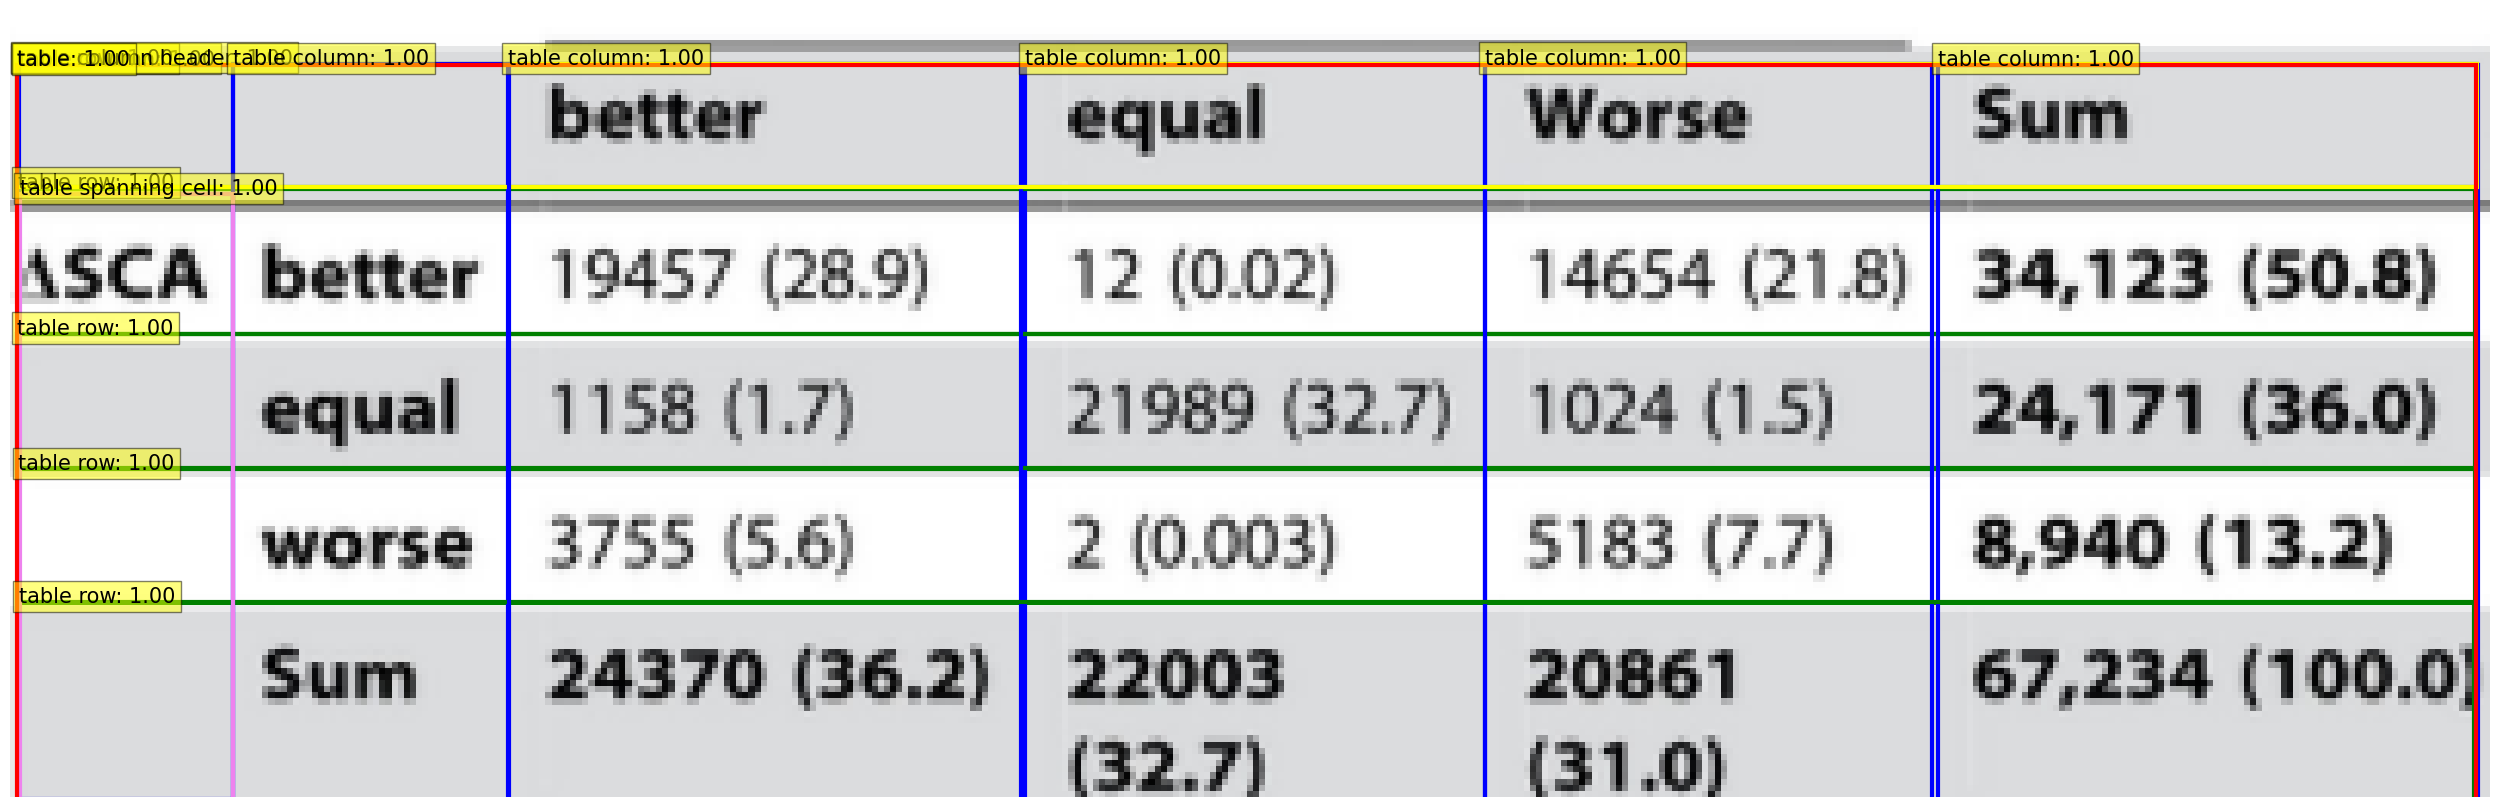

In [6]:
ft = formatter.extract(tables[0])
ft.visualize()

Since table #1 is an **image**, OCR is required (which you must handle externally.) The image can be obtained through ft.image(), which is a PIL image. This image can then be fed into an OCR of your choice, like paddlepaddle, tesseract, even GPT4-V, etc.

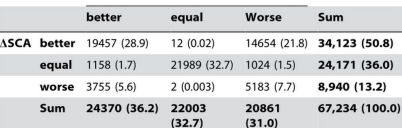

In [ ]:
ft.image(dpi=144)

Let's keep going

In [7]:
# <1s
ft = formatter.extract(tables[1])

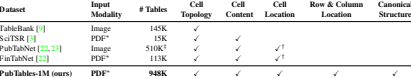

In [8]:
ft.image()

In [9]:
# <1s
ft.df()

Dataset Input Modality # Tables Cell Topology Cell Content  \
0        TableBank [9]          Image     145K             X         None   
1           SciTSR [3]           PDF∗      15K             X            X   
2   PubTabNet [22, 23]          Image    510K‡             X            X   
3       FinTabNet [22]           PDF∗     113K             X            X   
4  PubTables-1M (ours)           PDF∗     948K             X            X   

  Cell Location Row & Column Location Canonical Structure  
0          None                  None                None  
1          None                  None                None  
2            X†                  None                None  
3            X†                  None                None  
4             X                     X                   X

Now that table has text, gmft does better. You can call `table.text()` and `table.text_positions()` to, for instance, to filter results by keyword before parsing the table.

In [10]:
tables[1].text()

'Dataset\nInput\nModality\n# Tables\nCell\nTopology\nCell\nContent\nCell\nLocation\nRow & Column\nLocation\nCanonical\nStructure\nTableBank [9] Image 145K X\nSciTSR [3] PDF∗ 15K X X\nPubTabNet [22, 23] Image 510K‡ X X X†\nFinTabNet [22] PDF∗ 113K X X X†\nPubTables-1M (ours) PDF∗ 948K X X X X X'

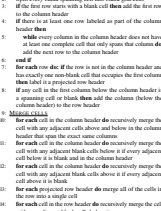

In [11]:
# 1s
ft = formatter.extract(tables[2])
ft.image(dpi=50)

It looks like table #3 is a false positive. You can see that the confidence score is much lower.

In [12]:
tables[2].label, tables[2].confidence_score

(0, 0.906853199005127)

In [14]:
ft.df()

\
0      2:  Split every blank spanning cell into blank gri...   
1      3:  if the first row starts with a blank cell then...   
2      4:  if there is at least one row labeled as part o...   
3   5: 6:  while every column in the column header does n...   
4      7:  for each row do: if the row is not in the colu...   
5      8:  has exactly one non-blank cell that occupies t...   
6      9:       column header) to the row header MERGE CELLS   
7     10:  for each cell in the column header do recursiv...   
8    None  cell with any adjacent cells above and below i...   
9     11:  header that span the exact same columns for ea...   
10    12:  for each cell in the column header do recursiv...   
11    13:  for each projected row header do merge all of ...   
12    14:  for each cell in the row header do recursively...   

    is_projecting_row  
0               False  
1               False  
2               False  
3               False  
4               False  
5               False  
6               False  
7                True  
8               False  
9               False  
10              False  
11              False  
12              False

Undeterred, let's see tables #4 & #5.

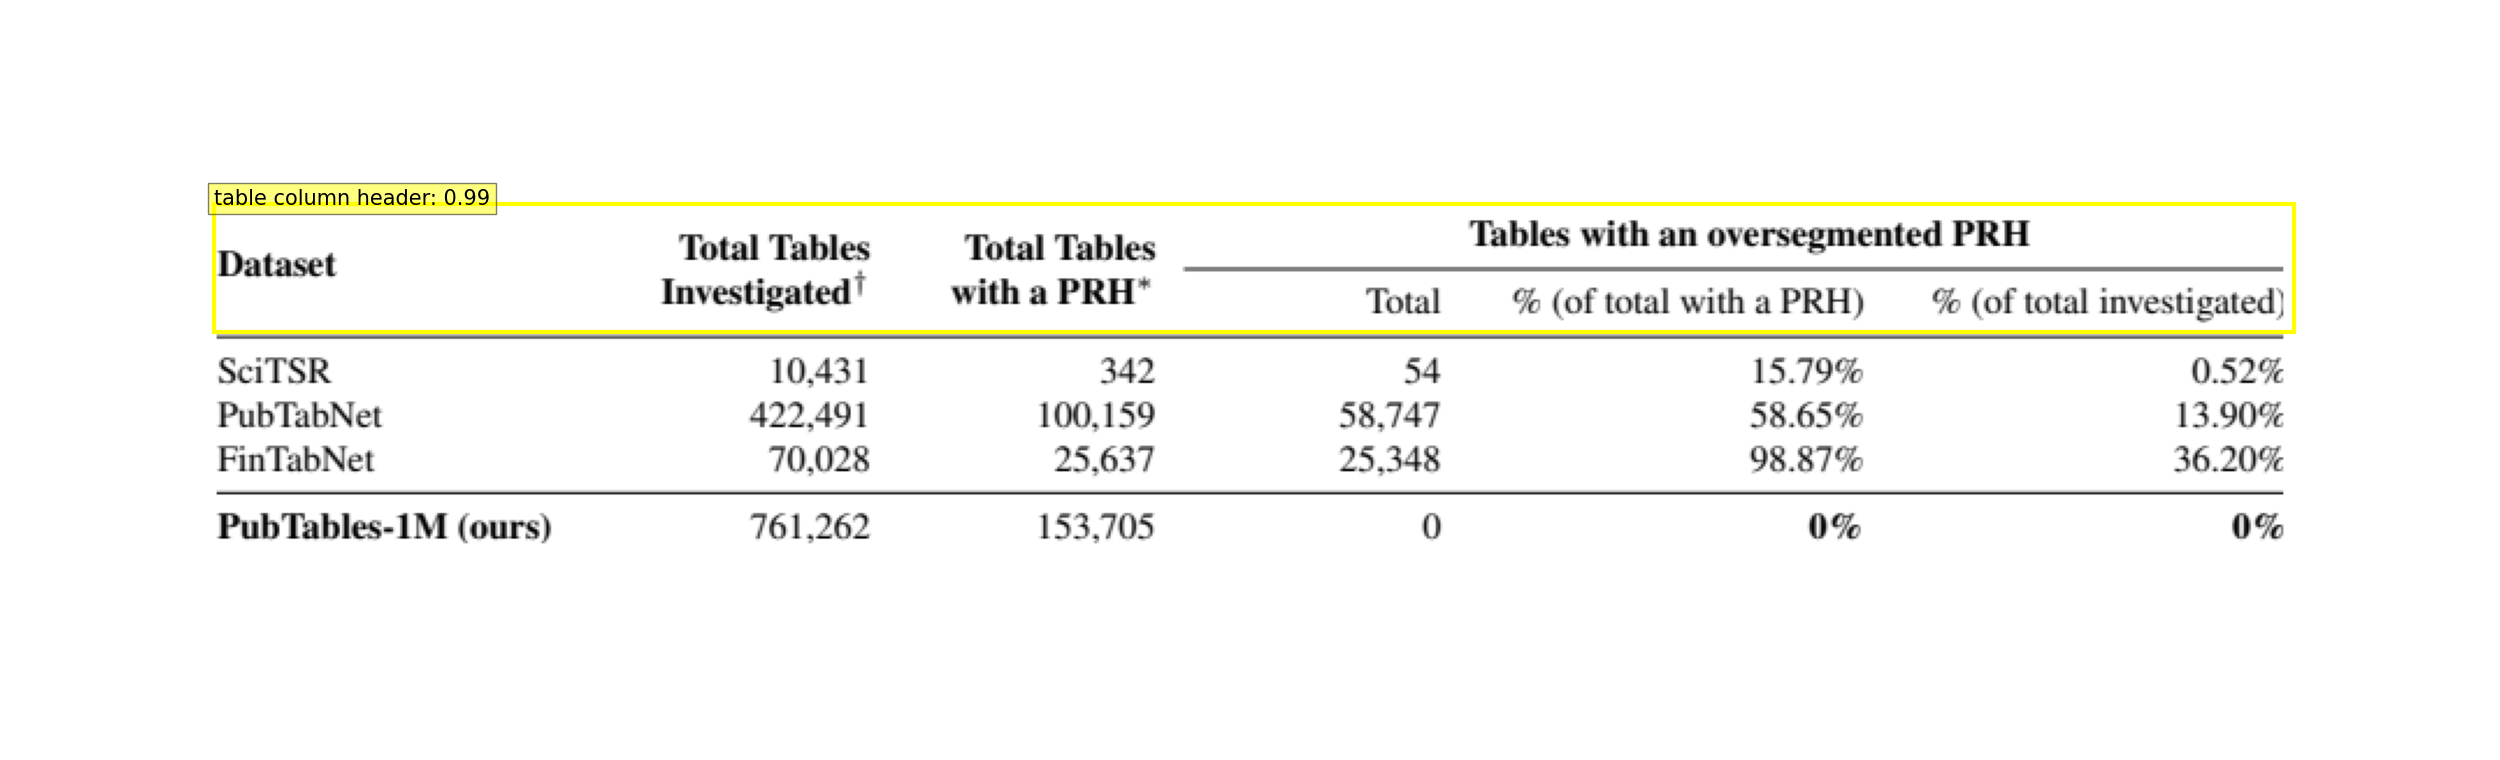

None

Dataset Total Tables Investigated† Total Tables with a PRH∗  \
0               SciTSR                     10,431                      342   
1            PubTabNet                    422,491                  100,159   
2            FinTabNet                     70,028                   25,637   
3  PubTables-1M (ours)                    761,262                  153,705   

    Total Tables with an oversegmented % (of total with a PRH)  \
0      54                                             15.79%     
1  58,747                                             58.65%     
2  25,348                                             98.87%     
3       0                                                 0%     

  PRH % (of total investigated)  
0                         0.52%  
1                        13.90%  
2                        36.20%  
3                            0%

In [15]:
from IPython.display import display

ft = formatter.extract(tables[3])
display(ft.visualize(filter=[3]))
ft.df()

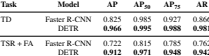

Task         Model     AP   AP50   AP75     AR
0        TD  Faster R-CNN  0.825  0.985  0.927  0.866
1      None          DETR  0.966  0.995  0.988  0.981
2  TSR + FA  Faster R-CNN  0.722  0.815  0.785  0.762
3      None          DETR  0.912  0.971  0.948  0.942

In [16]:
ft = formatter.extract(tables[4])
display(ft.image())
ft.df()

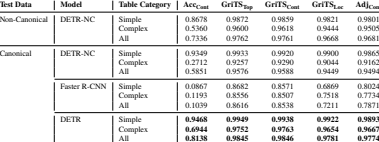

Test Data         Model Table Category AccCont GriTSTop GriTSCont  \
0   Non-Canonical       DETR-NC         Simple  0.8678   0.9872    0.9859   
1            None          None        Complex  0.5360   0.9600    0.9618   
2            None          None            All  0.7336   0.9762    0.9761   
3       Canonical       DETR-NC         Simple  0.9349   0.9933    0.9920   
4            None          None        Complex  0.2712   0.9257    0.9290   
5            None          None            All  0.5851   0.9576    0.9588   
6            None  Faster R-CNN         Simple  0.0867   0.8682    0.8571   
7            None          None        Complex  0.1193   0.8556    0.8507   
8            None          None            All  0.1039   0.8616    0.8538   
9            None          DETR         Simple  0.9468   0.9949    0.9938   
10           None          None        Complex  0.6944   0.9752    0.9763   
11           None          None            All  0.8138   0.9845    0.9846   

   GriTSLoc AdjCont  
0    0.9821  0.9801  
1    0.9444  0.9505  
2    0.9668  0.9681  
3    0.9900  0.9865  
4    0.9044  0.9162  
5    0.9449  0.9494  
6    0.6869  0.8024  
7    0.7518  0.7734  
8    0.7211  0.7871  
9    0.9922  0.9893  
10   0.9654  0.9667  
11   0.9781  0.9774

In [17]:
ft = formatter.extract(tables[5])
display(ft.image())
ft.df()

Important! With PyPDFium2, remember to close documents once you're done. This is especially important in loops.

In [18]:
doc.close()

### Paper 2: Attention

Let's look at the classic paper [Attention is All You Need](https://arxiv.org/abs/1706.03762) by Viswani et al.

In [ ]:
!wget -O ./samples/attention.pdf -q https://arxiv.org/pdf/1706.03762

In [19]:
# 22s
tables, doc = ingest_pdf('./samples/attention.pdf')
len(tables)

5

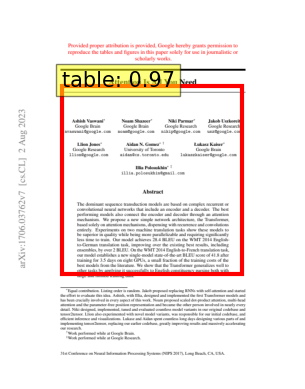

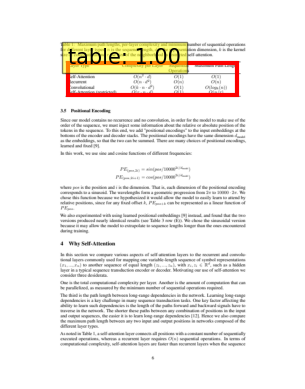

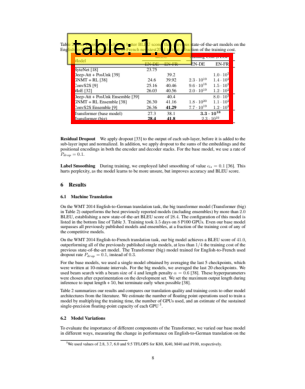

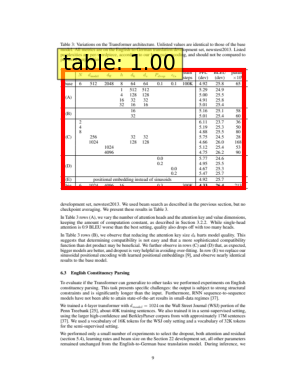

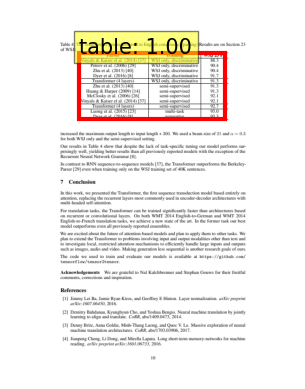

In [20]:
# display several images
# decrease size with plt
for table in tables:
    table.visualize(figsize=None)

In [21]:
ft = formatter.extract(tables[1])
ft.df()

Layer Type Complexity per Layer Sequential Operations  \
0               Self-Attention           O(n 2 · d)                  O(1)   
1                    Recurrent          O(n · d 2 )                  O(n)   
2                Convolutional      O(k · n · d 2 )                  O(1)   
3  Self-Attention (restricted)         O(r · n · d)                  O(1)   

  Maximum Path Length  
0                O(1)  
1                O(n)  
2          O(logk(n))  
3              O(n/r)

In [22]:
ft = formatter.extract(tables[2])
ft.df()

Model  EN-DE BLEU EN-FR Training EN-DE  \
1                      ByteNet [18]  23.75       None           None   
2            Deep-Att + PosUnk [39]   None       39.2           None   
3                    GNMT + RL [38]   24.6      39.92     2.3 · 1019   
4                       ConvS2S [9]  25.16      40.46     9.6 · 1018   
5                          MoE [32]  26.03      40.56     2.0 · 1019   
6   Deep-Att + PosUnk Ensemble [39]   None       40.4           None   
7           GNMT + RL Ensemble [38]  26.30      41.16     1.8 · 1020   
8              ConvS2S Ensemble [9]  26.36      41.29     7.7 · 1019   
9          Transformer (base model)   27.3       38.1          3.3 ·   
10                Transformer (big)   28.4       41.8          2.3 ·   

   Cost (FLOPs) EN-FR  
1                None  
2          1.0 · 1020  
3          1.4 · 1020  
4          1.5 · 1020  
5          1.2 · 1020  
6          8.0 · 1020  
7          1.1 · 1021  
8          1.2 · 1021  
9                1018  
10               1019

In [23]:
ft = formatter.extract(tables[3])
ft.df()

N dmodel         dff          h    dk          dv      Pdrop  \
0   base     6    512        2048          8    64          64        0.1   
1   None  None   None        None          1   512         512       None   
2   None  None   None        None          4   128         128       None   
3    (A)  None   None        None         16    32          32       None   
4   None  None   None        None         32    16          16       None   
5   None  None   None        None       None    16        None       None   
6    (B)  None   None        None       None    32        None       None   
7   None     2   None        None       None  None        None       None   
8   None     4   None        None       None  None        None       None   
9   None     8   None        None       None  None        None       None   
10   (C)  None    256        None       None    32          32       None   
11  None  None   1024        None       None   128         128       None   
12  None  None   None        1024       None  None        None       None   
13  None  None   None        4096       None  None        None       None   
14  None  None   None        None       None  None        None        0.0   
15  None  None   None        None       None  None        None        0.2   
16   (D)  None   None        None       None  None        None       None   
17  None  None   None        None       None  None        None       None   
18   (E)  None   None  positional  embedding  None  instead of  sinusoids   
19   big     6   1024        4096         16  None        None        0.3   

     ϵls train steps PPL (dev) BLEU (dev) params ×106  
0    0.1        100K      4.92       25.8          65  
1   None        None      5.29       24.9        None  
2   None        None      5.00       25.5        None  
3   None        None      4.91       25.8        None  
4   None        None      5.01       25.4        None  
5   None        None      5.16       25.1          58  
6   None        None      5.01       25.4          60  
7   None        None      6.11       23.7          36  
8   None        None      5.19       25.3          50  
9   None        None      4.88       25.5          80  
10  None        None      5.75       24.5          28  
11  None        None      4.66       26.0         168  
12  None        None      5.12       25.4          53  
13  None        None      4.75       26.2          90  
14  None        None      5.77       24.6        None  
15  None        None      4.95       25.5        None  
16   0.0        None      4.67       25.3        None  
17   0.2        None      5.47       25.7        None  
18  None        None      4.92       25.7        None  
19  None        300K      4.33       26.4         213

In [24]:
ft = formatter.extract(tables[4])
ft.df()

Parser                  Training WSJ 23 F1
0   Vinyals & Kaiser el al. (2014) [37]  WSJ only, discriminative      88.3
1             Petrov et al. (2006) [29]  WSJ only, discriminative      90.4
2                Zhu et al. (2013) [40]  WSJ only, discriminative      90.4
3                Dyer et al. (2016) [8]  WSJ only, discriminative      91.7
4                Transformer (4 layers)  WSJ only, discriminative      91.3
5                Zhu et al. (2013) [40]           semi-supervised      91.3
6            Huang & Harper (2009) [14]           semi-supervised      91.3
7           McClosky et al. (2006) [26]           semi-supervised      92.1
8   Vinyals & Kaiser el al. (2014) [37]           semi-supervised      92.1
9                Transformer (4 layers)           semi-supervised      92.7
10             Luong et al. (2015) [23]                multi-task      93.0
11               Dyer et al. (2016) [8]                generative      93.3

In [25]:
doc.close()

### Paper 3: NMR

Let's push the limit by extracting a difficult table with a lot of rows.

In [ ]:
!wget -O ./samples/nmr.pdf -q http://ccc.chem.pitt.edu/wipf/Web/NMR_Impurities.pdf

In [26]:
tables, doc = ingest_pdf('./samples/nmr.pdf')
len(tables)

5

In [27]:
print(tables[0].confidence_score)
tables[0].image()

0.9082970023155212


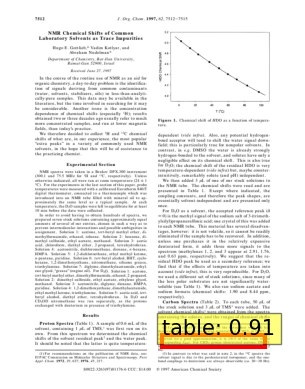

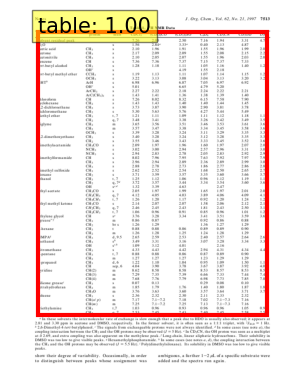

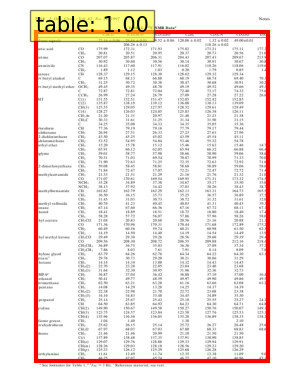

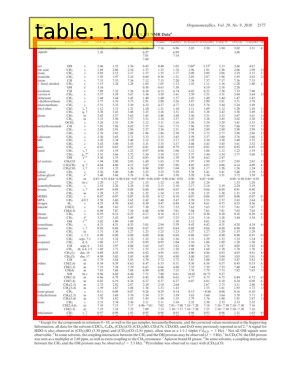

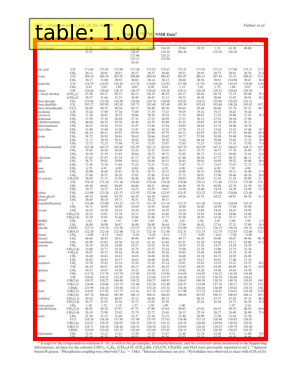

In [28]:
# display several images
for table in tables:
    table.visualize(figsize=None)

Invoking large table row guess! set TATRFormatConfig.large_table_threshold to 999 to disable this.


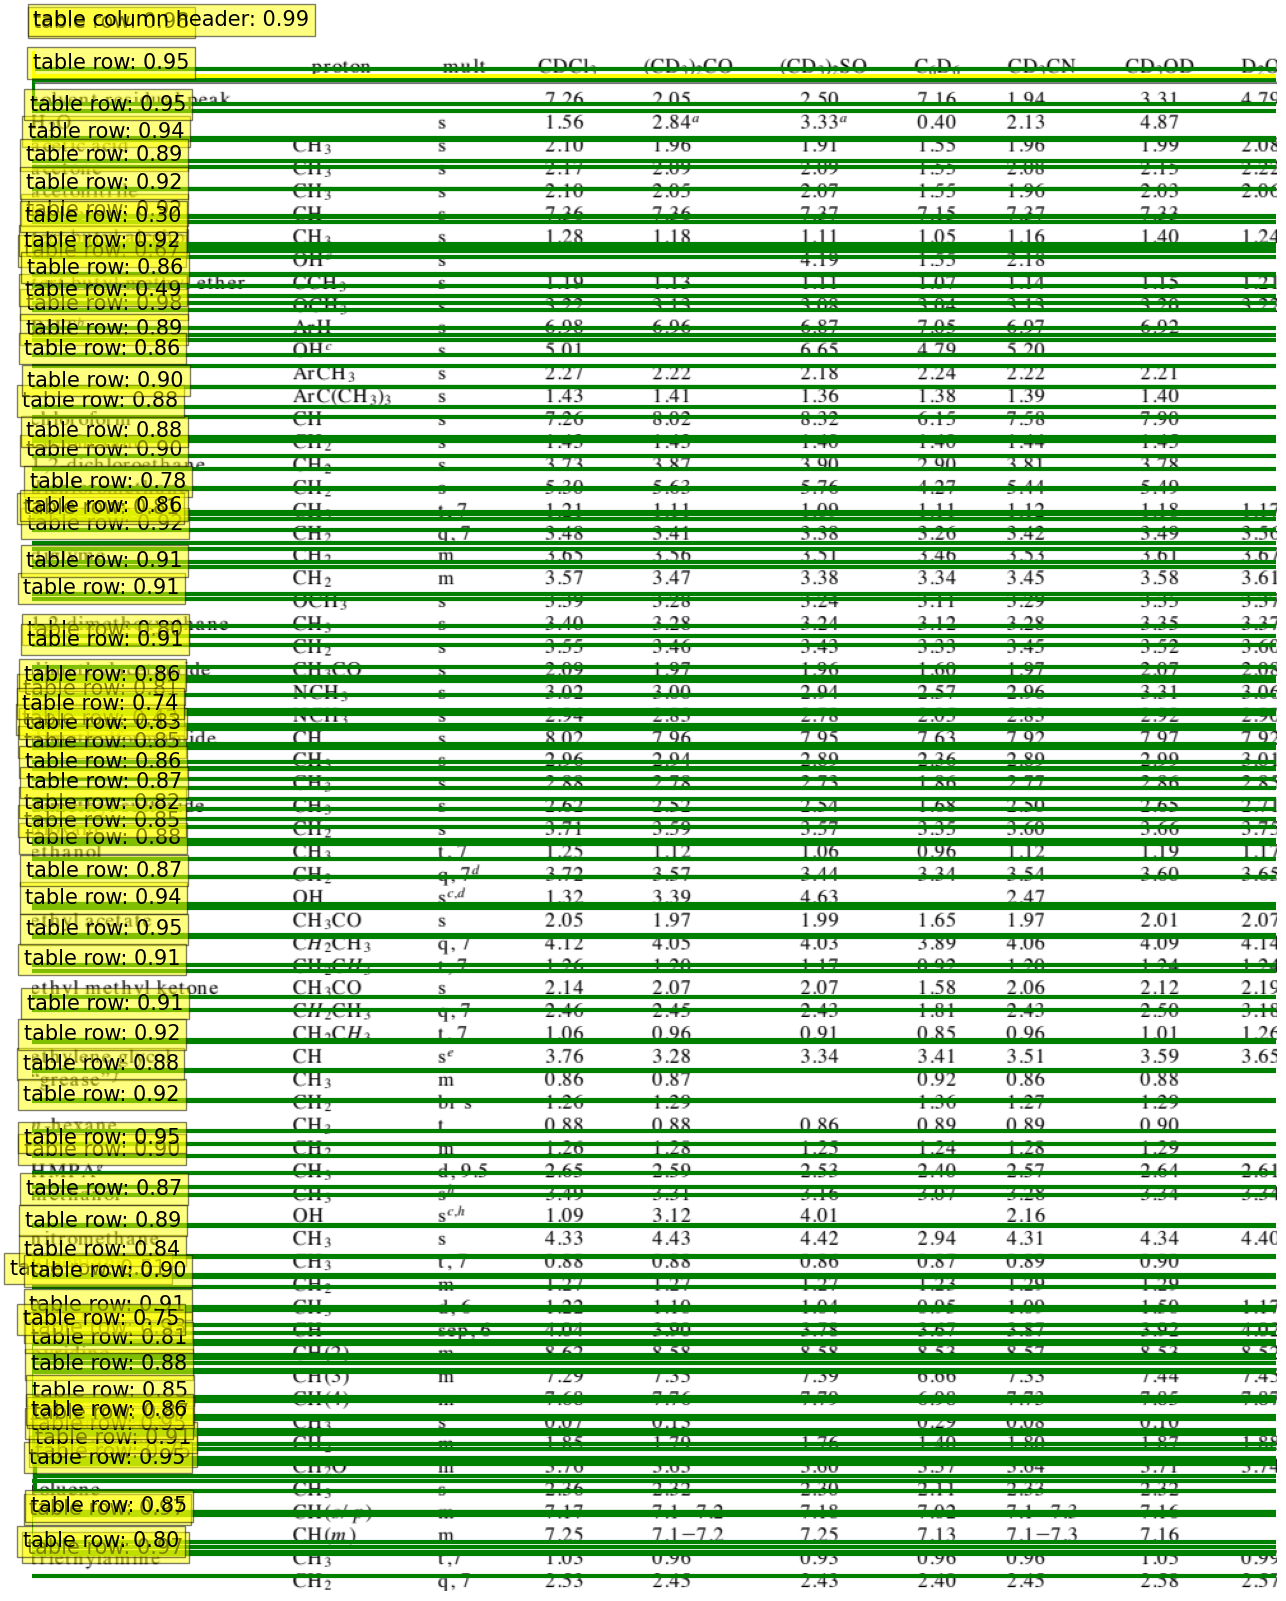

In [29]:
# 4s
ft1 = formatter.extract(tables[1])
ft1.visualize(filter=[2,3])

TATR's row detection struggles for large tables. However, for large tables gmft uses a procedural algorithm which takes advantage of the larger sample size.

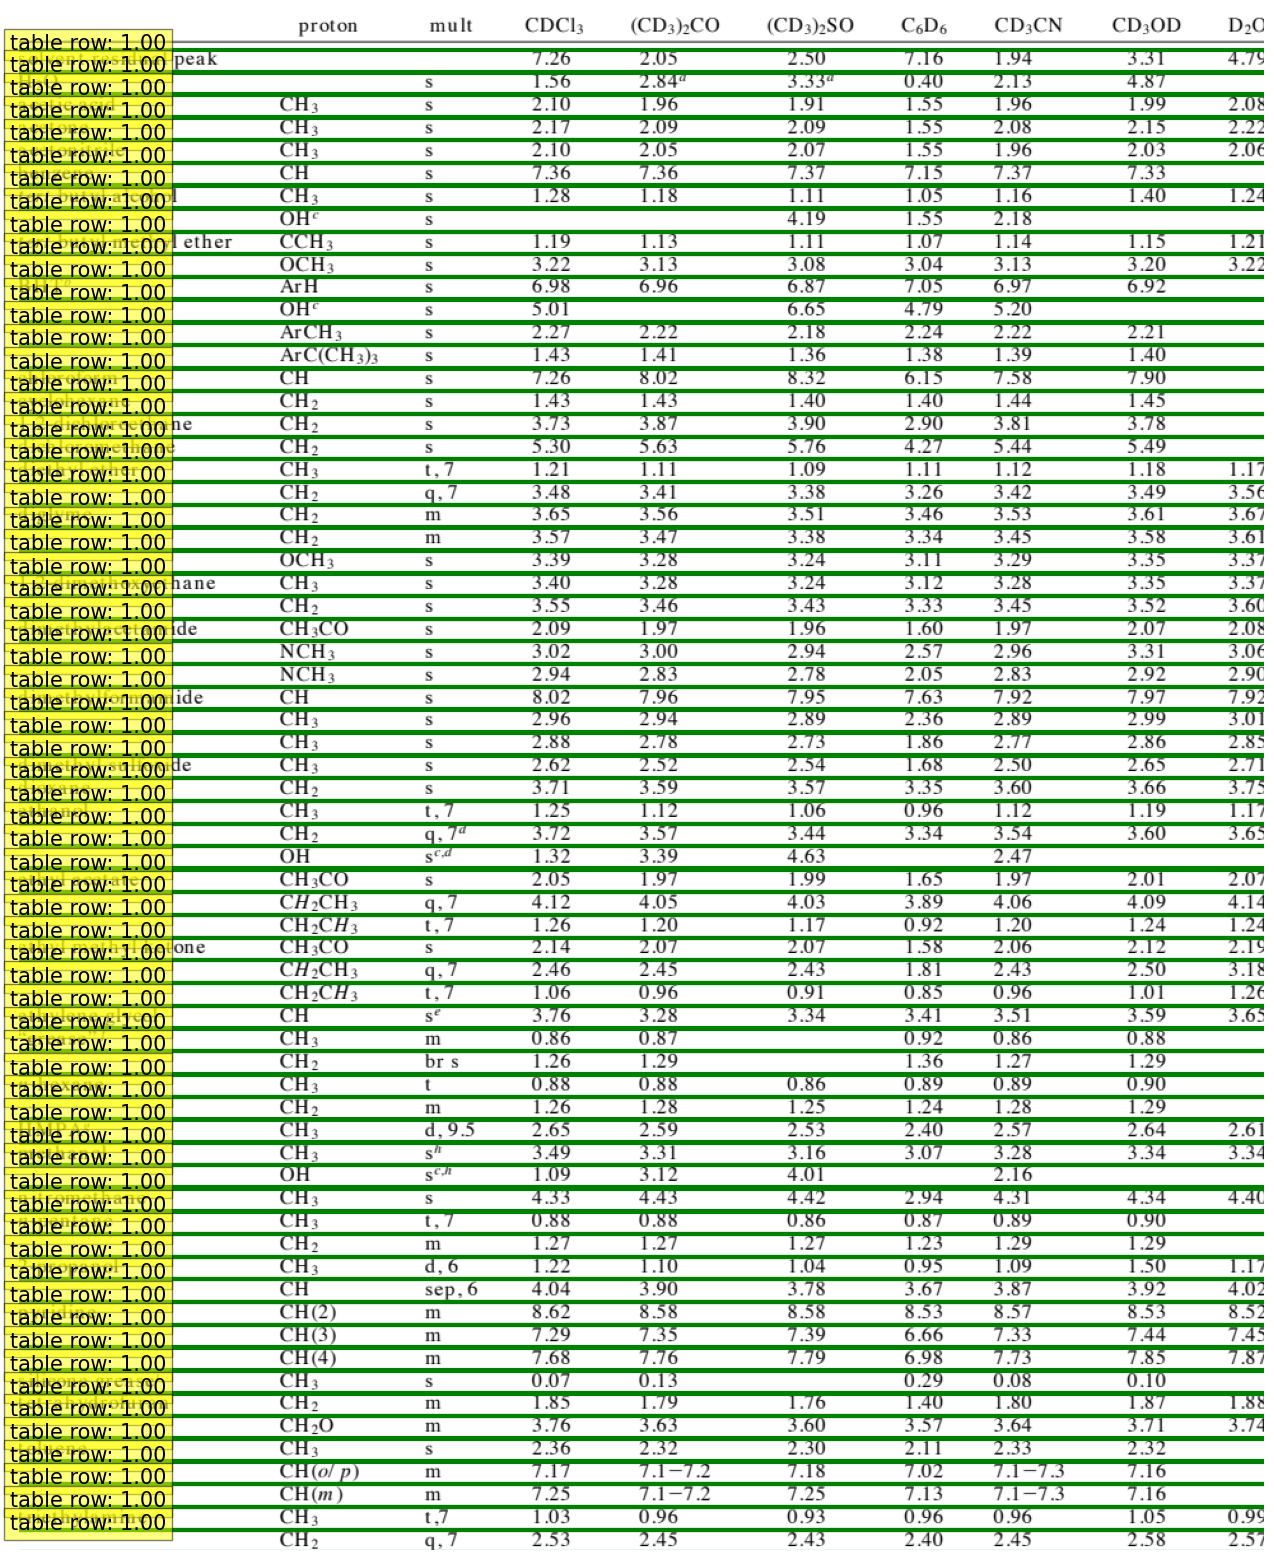

In [30]:
ft1.visualize(filter=[2], effective=True)

In [31]:
import pandas as pd
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(ft1.df())

pr ot on   m ult CDCl3 (CD3)2CO (CD3)2SO  \
0        solvent r esidu al pea k       None    None  7.26     2.05     2.50   
1                             H2O       None       s  1.56    2.84a    3.33a   
2                   a cetic a cid        CH3       s  2.10     1.96     1.91   
3                      a cet on e        CH3       s  2.17     2.09     2.09   
4                 a cet onit rile        CH3       s  2.10     2.05     2.07   
5                         benzene         CH       s  7.36     7.36     7.37   
6            tert-but yl alcoh ol        CH3       s  1.28     1.18     1.11   
7                            None        OHc       s  None     None     4.19   
8   tert-but yl m et h yl et h er       CCH3       s  1.19     1.13     1.11   
9                            None       OCH3       s  3.22     3.13     3.08   
10                           BHTb        ArH       s  6.98     6.96     6.87   
11                           None        OHc       s  5.01     None     6.65   
12                           None      ArCH3       s  2.27     2.22     2.18   
13                           None  ArC(CH3)3       s  1.43     1.41     1.36   
14                    chlor oform         CH       s  7.26     8.02     8.32   
15                 cycloh exa n e        CH2       s  1.43     1.43     1.40   
16        1,2-dichlor oet h a n e        CH2       s  3.73     3.87     3.90   
17          dichlor om et h a n e        CH2       s  5.30     5.63     5.76   
18                  diethyl ether        CH3    t, 7  1.21     1.11     1.09   
19                           None        CH2    q, 7  3.48     3.41     3.38   
20                        diglyme        CH2       m  3.65     3.56     3.51   
21                           None        CH2       m  3.57     3.47     3.38   
22                           None       OCH3       s  3.39     3.28     3.24   
23     1,2-dim et h oxyet h a n e        CH3       s  3.40     3.28     3.24   
24                           None        CH2       s  3.55     3.46     3.43   
25         dim et h yla cet amide      CH3CO       s  2.09     1.97     1.96   
26                           None       NCH3       s  3.02     3.00     2.94   
27                           None       NCH3       s  2.94     2.83     2.78   
28          dim et h ylform amide         CH       s  8.02     7.96     7.95   
29                           None        CH3       s  2.96     2.94     2.89   
30                           None        CH3       s  2.88     2.78     2.73   
31          dim et h yl sulfoxide        CH3       s  2.62     2.52     2.54   
32                      dioxa n e        CH2       s  3.71     3.59     3.57   
33                    et h a n ol        CH3    t, 7  1.25     1.12     1.06   
34                           None        CH2   q, 7d  3.72     3.57     3.44   
35                           None         OH    sc,d  1.32     3.39     4.63   
36             et h yl a cet at e      CH3CO       s  2.05     1.97     1.99   
37                           None     CH2CH3    q, 7  4.12     4.05     4.03   
38                           None     CH2CH3    t, 7  1.26     1.20     1.17   
39     et h yl m et h yl ket on e      CH3CO       s  2.14     2.07     2.07   
40                           None     CH2CH3    q, 7  2.46     2.45     2.43   
41                           None     CH2CH3    t, 7  1.06     0.96     0.91   
42             et h ylen e glycol         CH      se  3.76     3.28     3.34   
43                   “gr ea se” f        CH3       m  0.86     0.87     None   
44                           None        CH2    br s  1.26     1.29     None   
45                    n-h exa n e        CH3       t  0.88     0.88     0.86   
46                           None        CH2       m  1.26     1.28     1.25   
47                          HMPAg        CH3  d, 9.5  2.65     2.59     2.53   
48                  m et h a n ol        CH3      sh  3.49     3.31     3.16   
49                           None   

In general, having more rows with lower confidence is better than having fewer rows. Gmft is able to prune rows with no matches, so having an excess of rows is workable (as seen above). Meanwhile, having too few rows means that rows will be merged together, which is a pain.

Therefore, gmft tries a different approach for large tables. You can disable this approach by setting TATRFormatConfig.large_table_threshold to a very high number. For example, 

```

config = TATRFormatConfig()
ft = formatter.extract()

```


The image -> df step is heavily dependent on padding (see [this issue](https://github.com/microsoft/table-transformer/issues/158)). Therefore, it may be worth adjusting the padding if you get an unfavorable result.

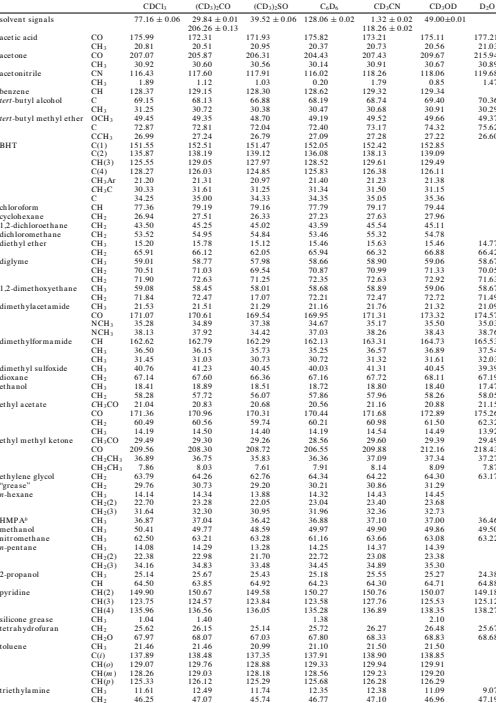

Invoking large table row guess! set TATRFormatConfig.large_table_threshold to 999 to disable this.


CDCl3       (CD3)2CO  \
0                solvent sign als          77.16 ( 0.06   29.84 ( 0.01   
1                                                        206.26 ( 0.13   
2                   a cetic a cid      CO        175.99         172.31   
3                                     CH3         20.81          20.51   
4                      a cet on e      CO        207.07         205.87   
5                                     CH3         30.92          30.60   
6                 a cet onit rile      CN        116.43         117.60   
7                                     CH3          1.89           1.12   
8                         benzene      CH        128.37         129.15   
9            tert-but yl alcoh ol       C         69.15          68.13   
10                                    CH3         31.25          30.72   
11  tert-but yl m et h yl et h er    OCH3         49.45          49.35   
12                                      C         72.87          72.81   
13                                   CCH3         26.99          27.24   
14                            BHT    C(1)        151.55         152.51   
15                                   C(2)        135.87         138.19   
16                                 CH (3)        125.55         129.05   
17                                   C(4)        128.27         126.03   
18                                  CH3Ar         21.20          21.31   
19                                   CH3C         30.33          31.61   
20                                      C         34.25          35.00   
21                    chlor oform      CH         77.36          79.19   
22                 cycloh exa n e     CH2         26.94          27.51   
23        1,2-dichlor oet h a n e     CH2         43.50          45.25   
24          dichlor om et h a n e     CH2         53.52          54.95   
25                  diethyl ether     CH3         15.20          15.78   
26                                    CH2         65.91          66.12   
27                        diglyme     CH3         59.01          58.77   
28                                    CH2         70.51          71.03   
29                                    CH2         71.90          72.63   
30     1,2-dim et h oxyet h a n e     CH3         59.08          58.45   
31                                    CH2         71.84          72.47   
32         dim et h yla cet amide     CH3         21.53          21.51   
33                                     CO        171.07         170.61   
34                                   NCH3         35.28          34.89   
35                                   NCH3         38.13          37.92   
36          dim et h ylform amide      CH        162.62         162.79   
37                                    CH3         36.50          36.15   
38                                    CH3         31.45          31.03   
39          dim et h yl sulfoxide     CH3         40.76          41.23   
40                      dioxa n e     CH2         67.14          67.60   
41                    et h a n ol     CH3         18.41          18.89   
42                                    CH2         58.28          57.72   
43             et h yl a cet at e   CH3CO         21.04          20.83   
44                                     CO        171.36         170.96   
45                                    CH2         60.49          60.56   
46                                    CH3         14.19          14.50   
47     et h yl m et h yl ket on e   CH3CO         29.49          29.30   
48                                     CO        209.56         208.30   
49                                 CH2CH3         36.89          36.75   
50                                 CH2CH3          7.86           8.03   
51             et h ylen e glycol     CH2         63.79          64.26   
52                     “gr ea se”     CH2         29.76          30.73   
53                    n-h exa n e     CH3         14.1

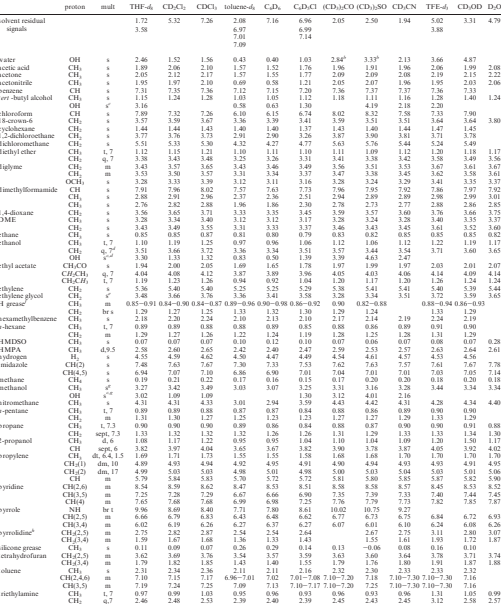

Invoking large table row guess! set TATRFormatConfig.large_table_threshold to 999 to disable this.


proton          mult     THF-d8     CD2Cl2  \
0      solvent residual                                1.72       5.32   
1               signals                                3.58              
2                                                                        
3                                                                        
4                 water         OH             s       2.46       1.52   
5           acetic acid        CH3             s       1.89       2.06   
6               acetone        CH3             s       2.05       2.12   
7          acetonitrile        CH3             s       1.95       1.97   
8               benzene         CH             s       7.31       7.35   
9   tert -butyl alcohol        CH3             s       1.15       1.24   
10                              OH            sc       3.16              
11           chloroform         CH             s       7.89       7.32   
12           18-crown-6        CH2             s       3.57       3.59   
13          cyclohexane        CH2             s       1.44       1.44   
14   1,2-dichloroethane        CH2             s       3.77       3.76   
15      dichloromethane        CH2             s       5.51       5.33   
16        diethyl ether        CH3          t, 7       1.12       1.15   
17                             CH2          q, 7       3.38       3.43   
18              diglyme        CH2             m       3.43       3.57   
19                             CH2             m       3.53       3.50   
20                            OCH3             s       3.28       3.33   
21    dimethylformamide         CH             s       7.91       7.96   
22                             CH3             s       2.88       2.91   
23                             CH3             s       2.76       2.82   
24          1,4-dioxane        CH2             s       3.56       3.65   
25                  DME        CH3             s       3.28       3.34   
26                             CH2             s       3.43       3.49   
27               ethane        CH3             s       0.85       0.85   
28              ethanol        CH3          t, 7       1.10       1.19   
29                             CH2         q, 7d       3.51       3.66   
30                              OH          sc,d       3.30       1.33   
31        ethyl acetate      CH3CO             s       1.94       2.00   
32                          CH2CH3          q, 7       4.04       4.08   
33                          CH2CH3          t, 7       1.19       1.23   
34             ethylene        CH2             s       5.36       5.40   
35                                             e                         
36      ethylene glycol        CH2             s       3.48       3.66   
37            H greasef        CH3             m  0.85-0.91  0.84-0.90   
38                             CH2          br s       1.29       1.27   
39    hexamethylbenzene        CH3             s       2.18       2.20   
40             n-hexane        CH3          t, 7       0.89       0.89   
41                             CH2             m       1.29       1.27   
42                HMDSO        CH3             s       0.07       0.07   
43                 HMPA        CH3         d,9.5       2.58       2.60   
44             hydrogen         H2             s       4.55       4.59   
45            imidazole      CH(2)             s       7.48       7.63   
46                         CH(4,5)             s       6.94       7.07   
47              methane        CH4             s       0.19       0.21   
48             methanol        CH3           s g       3.27       3.42   
49                              OH          sc,g       3.02       1.09   
50         nitromethane        CH3             s       4.31       4.31   
51            n-pentane        CH3          t, 7       0.89       0.89   
52                             CH2             m       1.31       1.30   
53              propane        C

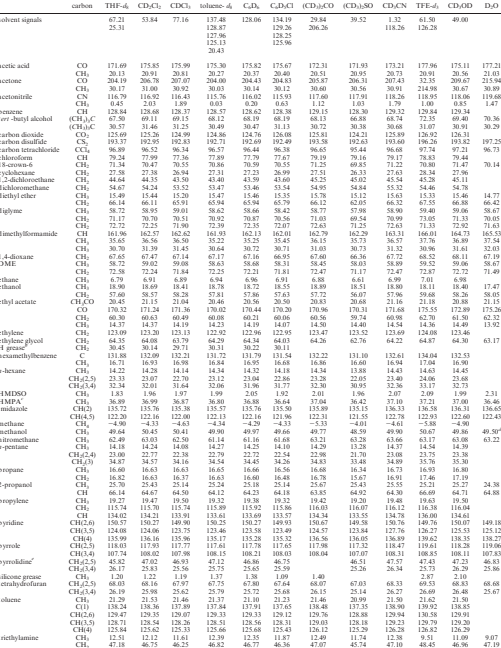

Invoking large table row guess! set TATRFormatConfig.large_table_threshold to 999 to disable this.


carbon  THF-d8  CD2Cl2   CDCl3 toluene- d8  \
0        solvent signals             67.21   53.84   77.16   137.48      
1                                    25.31                   128.87      
2                                                            127.96      
3                                                            125.13      
4                                                             20.43      
5            acetic acid        CO  171.69  175.85  175.99   175.30      
6                              CH3   20.13   20.91   20.81    20.27      
7                acetone        CO  204.19  206.78  207.07   204.00      
8                              CH3   30.17   31.00   30.92    30.03      
9           acetonitrile        CN  116.79  116.92  116.43   115.76      
10                             CH3    0.45    2.03    1.89     0.03      
11               benzene        CH  128.84  128.68  128.37   128.57      
12   tert -butyl alcohol   (CH3)3C   67.50   69.11   69.15    68.12      
13                         (CH3)3C   30.57   31.46   31.25    30.49      
14        carbon dioxide       CO2  125.69  125.26  124.99   124.86      
15      carbon disulfide       CS2  193.37  192.95  192.83   192.71      
16  carbon tetrachloride      CCl4   96.89   96.52   96.34    96.57      
17            chloroform        CH   79.24   77.99   77.36    77.89      
18            18-crown-6       CH2   71.34   70.47   70.55    70.86      
19           cyclohexane       CH2   27.58   27.38   26.94    27.31      
20    1,2-dichloroethane       CH2   44.64   44.35   43.50    43.40      
21       dichloromethane       CH2   54.67   54.24   53.52    53.47      
22         diethyl ether       CH3   15.49   15.44   15.20    15.47      
23                             CH2   66.14   66.11   65.91    65.94      
24               diglyme       CH3   58.72   58.95   59.01    58.62      
25                             CH2   71.17   70.70   70.51    70.92      
26                             CH2   72.72   72.25   71.90    72.39      
27     dimethylformamide        CH  161.96  162.57  162.62   161.93      
28                             CH3   35.65   36.56   36.50    35.22      
29                             CH3   30.70   31.39   31.45    30.64      
30           1,4-dioxane       CH2   67.65   67.47   67.14    67.17      
31                   DME       CH3   58.72   59.02   59.08    58.63      
32                             CH2   72.58   72.24   71.84    72.25      
33                ethane       CH3    6.79    6.91    6.89     6.94      
34               ethanol       CH3   18.90   18.69   18.41    18.78      
35                             CH2   57.60   58.57   58.28    57.81      
36         ethyl acetate     CH3CO   20.45   21.15   21.04    20.46      
37                              CO  170.32  171.24  171.36   170.02      
38                             CH2   60.30   60.63   60.49    60.08      
39                             CH3   14.37   14.37   14.19    14.23      
40              ethylene       CH2  123.09  123.20  123.13   122.92      
41       ethylene glycol       CH2   64.35   64.08   63.79    64.29      
42             H greaseb       CH2   30.45   30.14   29.71    30.31      
43     hexamethylbenzene         C  131.88  132.09  132.21   131.72      
44                             CH3   16.71   16.93   16.98    16.84      
45              n-hexane       CH3   14.22   14.28   14.14    14.34      
46                        CH2(2,5)   23.33   23.07   22.70    23.12      
47                        CH2(3,4)   32.34   32.01   31.64    32.06      
48                 HMDSO       CH3    1.83    1.96    1.97     1.99      
49                 HMPAc       CH3   36.89   36.99   36.87    36.80      
50             imidazole     CH(2)  135.72  135.76  135.38   135.57      
51                         CH(4,5)  122.20  122.16  122.00   122.13      
52               methane       CH4   -4.90   -4.33   -4.63    -4.34      
53              methanol       C

In [32]:
for i in range(2, 5):
    ft = formatter.extract(tables[i])
    display(ft.image())
    df = ft.df()
    df.fillna("",inplace=True)
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display(ft.df())

Also, be warned that false positives are be observed more often for rotated tables ( where `table.label == 1`)

In [33]:
ft.label

0

Finally, useful outlier/warning information may be stored in `ft.outliers`.

In [34]:
ft.outliers

{'narrow spanning cell': 2, 'high overlap': 0.06804632977623148}

In [35]:
doc.close()

In [36]:
# demonstrate custom configuration

from gmft import TATRFormatConfig
tables, doc = ingest_pdf('./samples/attention.pdf')


In [34]:
config = TATRFormatConfig()
config.remove_null_rows = False

# also possible: 
# formatter = AutoTableFormatter(config=config)
ft = formatter.extract(tables[2])

ft.config = config
ft.df()

Model  EN-DE BLEU EN-FR Training EN-DE  \
0                              None   None       None           None   
1                      ByteNet [18]  23.75       None           None   
2            Deep-Att + PosUnk [39]   None       39.2           None   
3                    GNMT + RL [38]   24.6      39.92     2.3 · 1019   
4                       ConvS2S [9]  25.16      40.46     9.6 · 1018   
5                          MoE [32]  26.03      40.56     2.0 · 1019   
6   Deep-Att + PosUnk Ensemble [39]   None       40.4           None   
7           GNMT + RL Ensemble [38]  26.30      41.16     1.8 · 1020   
8              ConvS2S Ensemble [9]  26.36      41.29     7.7 · 1019   
9          Transformer (base model)   27.3       38.1          3.3 ·   
10                Transformer (big)   28.4       41.8          2.3 ·   

   Cost (FLOPs) EN-FR  
0                None  
1                None  
2          1.0 · 1020  
3          1.4 · 1020  
4          1.5 · 1020  
5          1.2 · 1020  
6          8.0 · 1020  
7          1.1 · 1021  
8          1.2 · 1021  
9                1018  
10               1019

In [37]:
doc.close()

### Addendum: Benchmarks

This is run on Google Colab's **cpu**.

In [38]:
import time
_total_detect_time = 0
_total_detect_num = 0
_total_format_time = 0
_total_format_num = 0

for paper in ['tatr.pdf', 'attention.pdf', 'nmr.pdf']:
  start = time.time()
  tables, doc = ingest_pdf('./samples/' + paper)
  num_pages = len(doc)
  end_detect = time.time()
  for table in tables:
    tf = formatter.extract(table)
  end_format = time.time()
  doc.close()
  print(f"Paper: {paper}\nDetect time: {end_detect - start:.3f}s for {num_pages} pages")
  print(f"Format time: {end_format - end_detect:.3f}s for {len(tables)} tables\n")
  _total_detect_time += end_detect - start
  _total_detect_num += num_pages
  _total_format_time += end_format - end_detect
  _total_format_num += len(tables)
print(f"Macro: {_total_detect_time/_total_detect_num:.3f} s/page and {_total_format_time/_total_format_num:.3f} s/table ")

Paper: 2110.00061.pdf
Detect time: 13.730s for 10 pages
Format time: 4.247s for 6 tables

Paper: attention.pdf
Detect time: 21.085s for 15 pages
Format time: 4.801s for 5 tables

Paper: nmr.pdf
Detect time: 12.152s for 9 pages
Format time: 6.071s for 5 tables

Macro: 1.381 s/page and 0.945 s/table 
